## FFT Generierung

In [1]:
from enum import Enum
import ipywidgets as widgets
from pandas import read_csv
import pandas as pd
import asammdf
from IPython.display import display
import os
import numpy as np
import time
import pathlib as pl
import matplotlib.pyplot as plt
from scipy.fftpack import fft

ldf is not supported
xls is not supported
xlsx is not supported
yaml is not supported


In [3]:
# Setting up the global variables

# PATH_RAW_DATA = "../Messdaten"
PATH_RAW_DATA = r"E:\Messdaten"
PATH_FEATURE_DATA = "./data/"
PATH_EXPLORATION_DATA = "./exploration/"
PATH_MODEL = "./models/"
DATA_SOURCE_KIDAQ = ["TEST_NAME", "TEST_TYPE", "RPM", "FLOW_RATE", "P1", "P2"]
RAW_DATA_TYPE = ["KIDAQ", "VIB"]

DATA_SOURCE_VID = [
    "TEST_NAME",
    "TEST_TYPE",
    "RPM",
    "FLOW_RATE",
    "S1",
    "S2",
    "S3",
    "S4",
    "S5",
    "S6",
    "S7",
    "S8",
]
FEATURE = [
    "STD",
    "RANGE",
    "IQR",
    "MEAN_MEDIAN",
    "FFT",
]
OPERATING_POINT_FREQ = [725, 1450, 2175, 2900]
OPERATING_POINT_FLOW_RATE = [0, 25, 50, 75, 100]

PREPROCESSING_WINDOW_SIZE_MS_DEFAULT = 1000
PREPROCESSING_WINDOW_SIZE_MS_MIN = 100
PREPROCESSING_WINDOW_SIZE_MS_MAX = 10000

PREPROCESSING_FREQUENCY_BAND_COUNT_DEFAULT = 10
PREPROCESSING_FREQUENCY_BAND_COUNT_MIN = 10
PREPROCESSING_FREQUENCY_BAND_COUNT_MAX = 100

DEFAULT_RAW_DATA_TYPE = RAW_DATA_TYPE[0]
DEFAULT_RAW_DATA = DATA_SOURCE_KIDAQ
DEFAULT_SAMPLE_RATE = 10000

DEFAULT_CLASS_LABEL = "TEST_TYPE"
# 2021-04-28 - Gut 1, 2021-05-19 - Kavitation 1, 2021-05-26 - Fehlausrichtung 1, 2021-07-10 - Laufradschaden 1
TEST_TYPES = ["Gut", "Kavitation", "Fehlausrichtung", "Laufradschaden"]
TEST_TYPE_REGEX = r"\b(?:" + "|".join(TEST_TYPES) + r")\b"

# ..\Messdaten\Setup-I\2021-04-28 - Gut 1\KiDAQ\1450rpm\1450rpm@100%.mf4
TEST_NAME_REGEX = r"\d{4}-\d{2}-\d{2} - [\w\s]+"

KIDAQ_FILE_SEARCH_PATTERN = "**/*.mf4"  # 725rpm@0%.mf4
KIDAQ_FILE_RPM_REGEX = r"(\d+)rpm"
KIDAQ_FILE_FLOW_RATE_REGEX = r"(\d+)%"


KIDAQ_DEFAULT_FEATURES = [
    "test_name",
    "test_type",
    "flow_rate",
    "rpm",
    "p1_std",
    "p2_std",
    "p1_range",
    "p2_range",
    "p1_iqr",
    "p2_iqr",
    "p1_mean_median",
    "p2_mean_median",
]

VIB_DEFAULT_FEATURES = [
    "test_name",
    "test_type",
    "flow_rate",
    "rpm",
    "s1_std",
    "s2_std",
    "s3_std",
    "s4_std",
    "s5_std",
    "s6_std",
    "s7_std",
    "s8_std",
    "s1_range",
    "s2_range",
    "s3_range",
    "s4_range",
    "s5_range",
    "s6_range", 
    "s7_range",
    "s8_range",
    "s1_iqr",
    "s2_iqr",
    "s3_iqr",
    "s4_iqr",
    "s5_iqr",
    "s6_iqr",
    "s7_iqr",
    "s8_iqr",
    "s1_mean_median",
    "s2_mean_median",
    "s3_mean_median",
    "s4_mean_median",
    "s5_mean_median",
    "s6_mean_median",
    "s7_mean_median",
    "s8_mean_median"
]
    
# 2900_25_1.mf4

KIDAQ_FILE_FIX_REGEX = r"(\d+)_(\d+)_(\d+).mf4"


VIB_FILE_SEARCH_PATTERN = (
    "**/VIB*.csv"  # 725rpm\0%\1\VIB1 2021-05-03 10-58-02.453.519.300.csv
)
VIB_FILE_SENSOR_REGEX = r"VIB(\d+)"
VIB_FILE_RPM_REGEX = r"(\d+)rpm"
VIB_FILE_FLOW_RATE_REGEX = r"(\d+)%"
VIB_SENSOR_COUNT = 8


DATANALYSIS_WINDOW_SIZE_DEFAULT = 100000
DATANALYSIS_WINDOW_SIZE_MIN = 0
DATANALYSIS_WINDOW_SIZE_MAX = 1000000

DATANALYSIS_STEP_SIZE_DEFAULT = 100000
DATANALYSIS_STEP_SIZE_MIN = 0
DATANALYSIS_STEP_SIZE_MAX = 1000000

In [4]:
setups = list(filter(lambda x: os.path.isdir(os.path.join(PATH_RAW_DATA, x)), os.listdir(PATH_RAW_DATA)))
setupSelectionDropdown = widgets.Dropdown(
    options=setups,
    description='Setup:'
)
display(setupSelectionDropdown)


# list all folder in the selected setup and order by name of folder
seriesNames = sorted(list(filter(lambda x: os.path.isdir(os.path.join(PATH_RAW_DATA, setupSelectionDropdown.value, x)), os.listdir(os.path.join(PATH_RAW_DATA, setupSelectionDropdown.value)))))
seriesDropdown = widgets.Dropdown(
    options=seriesNames,
    description='Series:',
    value=seriesNames[1]
)
# if setupSelectionDropdown.value changes update seriesDropdown
def updateSeriesDropdown(change):
    seriesNames = sorted(list(filter(lambda x: os.path.isdir(os.path.join(PATH_RAW_DATA, setupSelectionDropdown.value, x)), os.listdir(os.path.join(PATH_RAW_DATA, setupSelectionDropdown.value)))))
    seriesDropdown.options = seriesNames
setupSelectionDropdown.observe(updateSeriesDropdown, names='value')
display(seriesDropdown)


dataSourceDropdown = widgets.Dropdown(
    options=RAW_DATA_TYPE,
    description='Data source:',
    value=RAW_DATA_TYPE[0]
)
display(dataSourceDropdown)


# create Pathlib Path to the selected series
def createPathToSeries(setup, series):
    return os.path.join(PATH_RAW_DATA, setup, series)

# list all files in all subfolders of createPathToSeries if data source is KIDAQ file should end with .mf4 else with .csv use function createPathToSeries
def listFilesInPath(path):
    files = []
    if dataSourceDropdown.value == 'KIDAQ':
        for file in pl.Path(path).glob(KIDAQ_FILE_SEARCH_PATTERN):
            # append full file path as string to files list
            files.append(file) 
    else:
        if path is None:
            return []
        for file in pl.Path(path).glob(VIB_FILE_SEARCH_PATTERN):
            files.append(file)
    return sorted(files)

fileDropdown = widgets.Dropdown(
    options=listFilesInPath(createPathToSeries(setupSelectionDropdown.value, seriesDropdown.value)),
    description='File:'
)
# if one of the dropdowns changes update fileDropdown
def updateFileDropdown(change):
    fileDropdown.options = listFilesInPath(createPathToSeries(setupSelectionDropdown.value, seriesDropdown.value))
setupSelectionDropdown.observe(updateFileDropdown, names='value')
seriesDropdown.observe(updateFileDropdown, names='value')
dataSourceDropdown.observe(updateFileDropdown, names='value')
display(fileDropdown)

# add button with refresh icon to refresh columns of the selected file
refreshColumnsButton = widgets.Button(
    description='Refresh columns',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Refresh columns',
    icon='refresh'
)
display(refreshColumnsButton)

# read the selected file and return a pandas dataframe
def readFile():
    # check if path is not None return empty dataframe
    if fileDropdown.value is None:
        return pd.DataFrame()
    if dataSourceDropdown.value == 'KIDAQ':
        return asammdf.MDF(fileDropdown.value).to_dataframe()
    elif dataSourceDropdown.value == 'VIB':
        # return pd dataframe with only the first 2 columns delete the 3 row and set the second row as header
        df = pd.read_csv(fileDropdown.value, sep=';', encoding = "ISO-8859-1", header=1, usecols=[0,1], low_memory=False)
        # rename the first column to 'Timestamp [ns]'
        df.rename(columns={df.columns[0]: 'Timestamp [ns]'}, inplace=True)
        # delete the first row
        df = df.iloc[1:]
        # set the first column as index
        df.set_index(df.columns[0], inplace=True)
        # return the dataframe
        return df
        
        

# create a list of all columns of the selected file
def getColumnsToList():
    return list(readFile().columns.to_list())

multiselectColumns = widgets.SelectMultiple(
    options=[],
    description='Columns:',
    disabled=False
)
# if refreshColumnsButton is clicked update multiselectColumns
def refreshColumnsButtonClicked(b):
    multiselectColumns.options = getColumnsToList()
refreshColumnsButton.on_click(refreshColumnsButtonClicked)
# if one of the dropdowns changes update multiselectColumns to empty list
def updateMultiselectColumns(change):
    multiselectColumns.options = []
setupSelectionDropdown.observe(updateMultiselectColumns, names='value')
seriesDropdown.observe(updateMultiselectColumns, names='value')
dataSourceDropdown.observe(updateMultiselectColumns, names='value')
fileDropdown.observe(updateMultiselectColumns, names='value')
display(multiselectColumns)

# use the selected columns and the selected file to create fourier transform plot without matplotlib
def createFFTPlot(columns):
    df = readFile()
    # create a list of all columns of the selected file
    columns = list(columns)
    
    

    

# create button to plot the selected columns
plotButton = widgets.Button(
    description='Plot',
    disabled=True,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Plot',
    icon='check'
)
# if plotButton is clicked plot the selected columns
def plotButtonClicked(b):
    createFFTPlot(multiselectColumns.value, fileDropdown.value)
plotButton.on_click(plotButtonClicked)
# if no column is selected disable plotButton
def updatePlotButton(change):
    if len(multiselectColumns.value) == 0:
        plotButton.disabled = True
    else:
        plotButton.disabled = False
multiselectColumns.observe(updatePlotButton, names='value')
display(plotButton)

Dropdown(description='Setup:', options=('Setup-I', 'Setup-II'), value='Setup-I')

Dropdown(description='Series:', index=1, options=('2021-04-28 - Gut 1', '2021-04-30 - Gut 2', '2021-05-19 - Ka…

Dropdown(description='Data source:', options=('KIDAQ', 'VIB'), value='KIDAQ')

Dropdown(description='File:', options=(WindowsPath('E:/Messdaten/Setup-I/2021-04-30 - Gut 2/KiDAQ/1450rpm/1450…

Button(button_style='success', description='Refresh columns', icon='refresh', style=ButtonStyle(), tooltip='Re…

SelectMultiple(description='Columns:', options=(), value=())

Button(button_style='success', description='Plot', disabled=True, icon='check', style=ButtonStyle(), tooltip='…

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

def plot_fft(df, columns):
    # Daten aus den angegebenen Spalten extrahieren
    data = df[columns]

    # Zeitachse erstellen
    time = np.array([int(td.total_seconds()) for td in data.index])

    # FFT für jede Spalte berechnen
    fft_data = {}
    for column in columns:
        column_data = data[column].to_numpy()  # Daten in ein NumPy-Array konvertieren
        column_data = np.ascontiguousarray(column_data)  # Daten ausrichten
        fft_data[column] = np.abs(fft(column_data))
    # Plotten der FFT
    plt.figure(figsize=(10, 6))
    for column in columns:
        plt.plot(time, fft_data[column], label=column)
    plt.xlabel('Zeit (Sekunden)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.title('FFT-Plot')
    plt.show()

In [29]:
columns = list(multiselectColumns.value)
df = readFile()
# set index to time delta in seconds
df.index = pd.to_timedelta(df.index, unit="s")

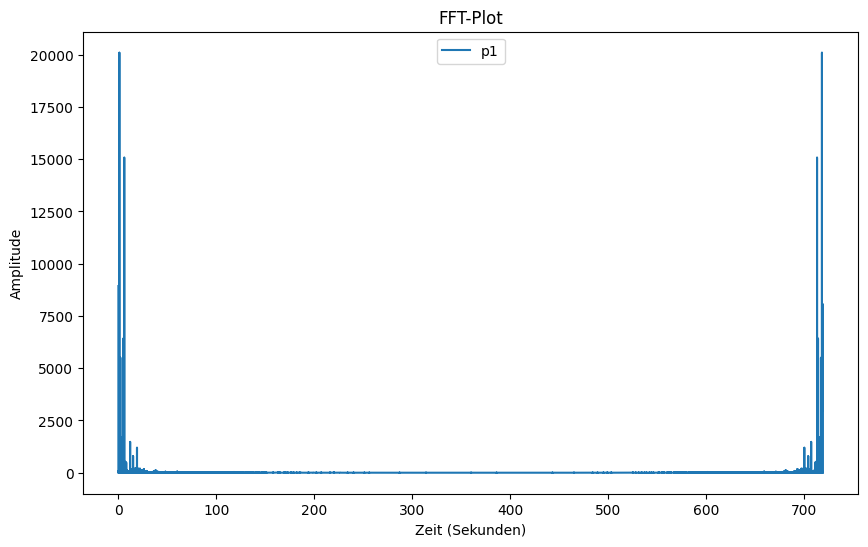

In [30]:
plot_fft(df, columns)

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_fft(dataframe):
    # Berechnung der Anzahl der Spalten im Dataframe
    num_columns = len(dataframe.columns)
    
    # Erstellung der Plots für jede Spalte
    for i, column in enumerate(dataframe.columns):
        plt.figure(figsize=(10, 6))
        plt.title(f"FFT Plot - {column}")
        
        # Extrahieren der Vibrationsdaten aus der aktuellen Spalte
        vibrations = dataframe[column].values
        
        # Durchführung des FFT
        fft = np.fft.fft(vibrations)
        freq = np.fft.fftfreq(len(vibrations))
        
        # Bestimmung der positiven Frequenzen
        positive_freq = freq > 0
        
        # Plotten des Amplitudenspektrums
        plt.plot(freq[positive_freq], np.abs(fft[positive_freq]))
        plt.xlabel("Frequency")
        plt.ylabel("Amplitude")
        
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [42]:
columns = list(multiselectColumns.value)
df = readFile()
# columns
df = df[columns]
# set index to time delta in seconds
df.index = pd.to_timedelta(df.index, unit="s")

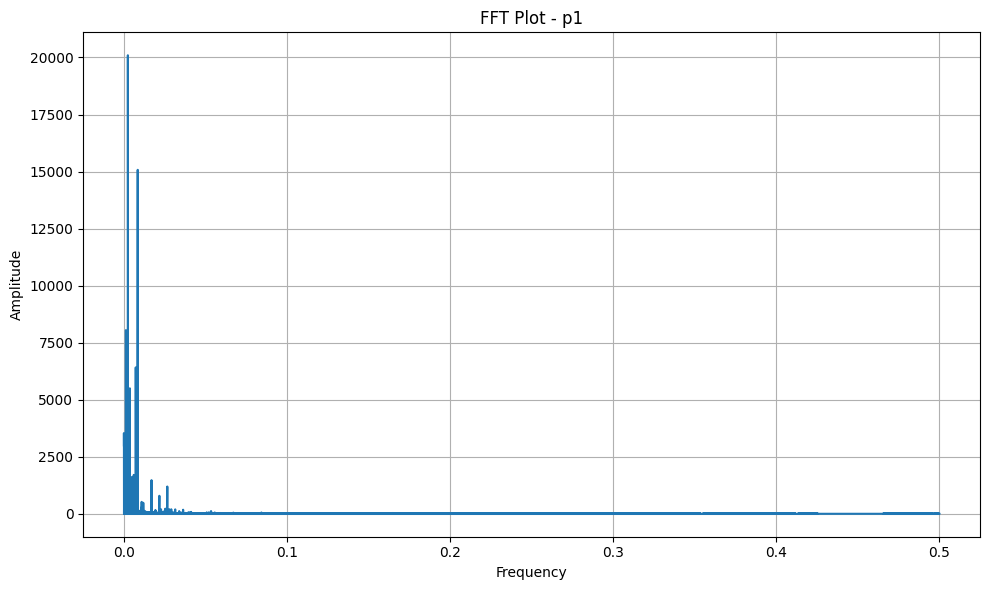

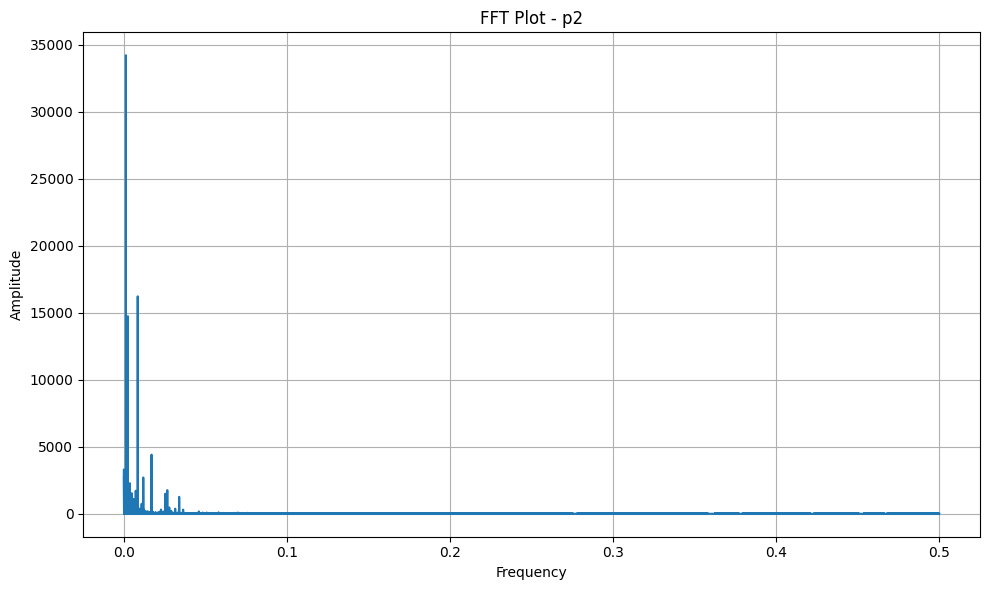

In [43]:
plot_fft(df)